In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
df = pd.read_csv('/kaggle/input/human-protein-atlas-image-classification/train.csv')

In [3]:
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 16
path_to_train = '/kaggle/input/human-protein-atlas-image-classification/train/'

In [4]:
df["complete_path"] = path_to_train + df["Id"]

In [5]:
df.head()

,Id,Target,complete_path
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,/kaggle/input/human-protein-atlas-image-classi...
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,/kaggle/input/human-protein-atlas-image-classi...
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,/kaggle/input/human-protein-atlas-image-classi...
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,/kaggle/input/human-protein-atlas-image-classi...
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,/kaggle/input/human-protein-atlas-image-classi...


In [6]:
print(df.iloc[0, :])

print(np.array(Image.open('/kaggle/input/human-protein-atlas-image-classification/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png')))

Id                            00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
Target                                                        16 0
complete_path    /kaggle/input/human-protein-atlas-image-classi...
Name: 0, dtype: object
[[ 0  0 21 ...  9  0  0]
 [ 5  7  9 ...  0  0  0]
 [12  7 14 ...  0  0  0]
 ...
 [ 5  2  1 ...  0  0  0]
 [ 6  3  0 ...  0  0  0]
 [ 3  4  2 ...  0  0  0]]


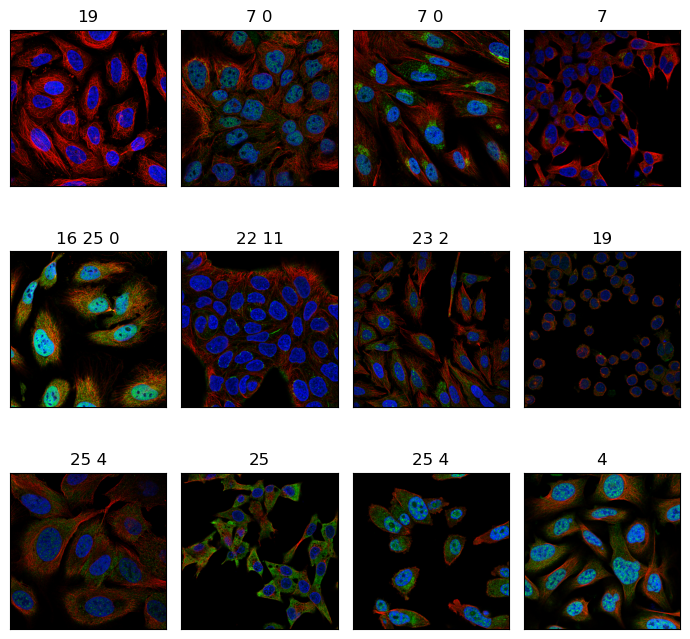

In [7]:
import random
fig, axes = plt.subplots(3, 4, figsize=(7, 7))
for i in range(3):
    for j in range(4):
        idx = random.randint(0, df.shape[0])
        row = df.iloc[idx, :]
        path = row.complete_path
        red = np.array(Image.open(path + '_red.png'))
        green = np.array(Image.open(path + '_green.png'))
        blue = np.array(Image.open(path + '_blue.png'))
        im = np.stack((
            red,
            green,
            blue), axis=-1) # axis=-1은 마지막 axis를 의미한다. 
        axes[i][j].imshow(im)
        axes[i][j].set_title(row.Target)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
fig.tight_layout()
fig.show()
        

In [8]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
print(f'Shape of train: {train.shape}')
print(f'Shape of val: {val.shape}')

Shape of train: (24857, 3)
Shape of val: (6215, 3)


In [10]:
def get_clean_data(df):
    targets = []
    paths = []
    for _, row in df.iterrows():
        target_np = np.zeros((28))
        t = [int(t) for t in row.Target.split()]
        target_np[t] = 1
        targets.append(target_np)
        paths.append(row.complete_path)
    return np.array(paths), np.array(targets)

In [11]:
train_path, train_target = get_clean_data(train)
val_path, val_target = get_clean_data(val)

print(train_path[:5])
print(train_target[:5])

['/kaggle/input/human-protein-atlas-image-classification/train/a2f60dd4-bbac-11e8-b2ba-ac1f6b6435d0'
 '/kaggle/input/human-protein-atlas-image-classification/train/84e33aee-bba5-11e8-b2ba-ac1f6b6435d0'
 '/kaggle/input/human-protein-atlas-image-classification/train/07249288-bbc3-11e8-b2bc-ac1f6b6435d0'
 '/kaggle/input/human-protein-atlas-image-classification/train/45693d7a-bbad-11e8-b2ba-ac1f6b6435d0'
 '/kaggle/input/human-protein-atlas-image-classification/train/d83cc910-bbac-11e8-b2ba-ac1f6b6435d0']
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0.]]


In [12]:
print(f'Train path shape: {train_path.shape}')
print(f'Train target shape: {train_target.shape}')
print(f'Val path shape: {val_path.shape}')
print(f'Val target shape: {val_target.shape}')

Train path shape: (24857,)
Train target shape: (24857, 28)
Val path shape: (6215,)
Val target shape: (6215, 28)


## CREATING DATASET FROM FILE AND TARGETS

In [13]:
train_data = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val_data = tf.data.Dataset.from_tensor_slices((val_path, val_target))

## READING IMAGES FROM FILES

In [14]:
sample = tf.image.decode_png(tf.io.read_file('/kaggle/input/human-protein-atlas-image-classification/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png'), channels=1)
sample.shape

TensorShape([512, 512, 1])

In [15]:
def load_data(path, target):
    # squeeze를 통해 크기가 1인 차원을 제거한다. [2]는 axis로 해당 axis의 크기가 1인 차원만 제거할 수도있다.
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_red.png'), channels=1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_blue.png'), channels=1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_green.png'), channels=1), [2])
    img = tf.stack((
                red,
                green,
                blue), axis=2)
    return img, target

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.map(load_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(load_data, num_parallel_calls=AUTOTUNE)

# 이미지를 resize하고 싶으면 tf.image.resize_images 함수를 사용하면 된다. 

## IMAGE AUGMENTATION

In [16]:
# contrast, brightness, flip 등을 활용해 IMAGE AUGMENTATION을 진행한다. 

def image_augment(img, target):
    img = tf.image.random_contrast(img, lower=0.3, upper=2.0)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, target
    
train_data = train_data.map(image_augment, num_parallel_calls=AUTOTUNE)

In [17]:
train_data_batches = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_data_batches = val_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

## TRAINING

In [19]:
# pretrained된 ResNet50에 마지막 layer를 추가해줘서 training을 한다. 

resnet_model = applications.ResNet50(include_top=False, weights='imagenet')

resnet_model.trainable = True 

input_layer = Input(shape=INPUT_SHAPE)
x = resnet_model(input_layer)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(28, activation='sigmoid')(x)
model = Model(input_layer, output)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dropout (Dropout)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

In [20]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [21]:
history = model.fit(train_data_batches, steps_per_epoch = 150, validation_data = val_data_batches, epochs=3)

Epoch 1/3
150/150 [==============================] - 245s 2s/step - loss: 0.3705 - binary_accuracy: 0.9290 - val_loss: 0.4476 - val_binary_accuracy: 0.9422
Epoch 2/3
150/150 [==============================] - 158s 1s/step - loss: 0.1895 - binary_accuracy: 0.9412 - val_loss: 0.1767 - val_binary_accuracy: 0.9471
Epoch 3/3
150/150 [==============================] - 147s 987ms/step - loss: 0.1838 - binary_accuracy: 0.9432 - val_loss: 0.5076 - val_binary_accuracy: 0.9421


In [18]:
# Use BatchNormalization

resnet_model2 = applications.ResNet50(include_top=False, weights='imagenet')

resnet_model2.trainable = True 

input_layer2 = Input(shape=INPUT_SHAPE)
x2 = resnet_model2(input_layer2)
x2 = Flatten()(x2)
x2 = Dense(512)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dense(28)(x2)
x2 = BatchNormalization()(x2)
output2 = Activation('sigmoid')(x2)
model2 = Model(input_layer2, output2)

model2.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0      

In [19]:
model2.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [20]:
history = model2.fit(train_data_batches, steps_per_epoch = 150, validation_data = val_data_batches, epochs=3)

Epoch 1/3
150/150 [==============================] - 228s 1s/step - loss: 0.7369 - binary_accuracy: 0.4665 - val_loss: 9.3202 - val_binary_accuracy: 0.6395
Epoch 2/3
150/150 [==============================] - 130s 870ms/step - loss: 0.6539 - binary_accuracy: 0.6399 - val_loss: 1.4490 - val_binary_accuracy: 0.7850
Epoch 3/3
150/150 [==============================] - 146s 978ms/step - loss: 0.5834 - binary_accuracy: 0.8267 - val_loss: 12.1027 - val_binary_accuracy: 0.7716


# Reference 
https://www.kaggle.com/code/hrithikadodia/human-protein-atlas-with-tf-data